In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r"C:\Users\nnnam\OneDrive\Documents\fleet-monthly-csvs-10-v3-2019\fleet-monthly-csvs-10-v3-2019-08-01.csv")
df.head()

,date,year,month,cell_ll_lat,cell_ll_lon,flag,geartype,hours,fishing_hours,mmsi_present
0,2019-08-01,2019,8,-34.0,-53.1,AFG,fishing,37.8338,0.0000,1
1,2019-08-01,2019,8,-33.2,-51.7,AFG,fishing,13.4411,0.0000,1
2,2019-08-01,2019,8,-32.9,-51.6,AFG,fishing,0.3408,0.0000,1
3,2019-08-01,2019,8,-32.3,-52.0,AFG,fishing,11.3813,11.0383,1
4,2019-08-01,2019,8,-32.2,-52.2,AFG,fishing,56.4136,0.0000,1


In [3]:
df.tail()

,date,year,month,cell_ll_lat,cell_ll_lon,flag,geartype,hours,fishing_hours,mmsi_present
1015252,2019-08-01,2019,8,38.0,120.6,ZAF,set_gillnets,0.3891,0.0000,1
1015253,2019-08-01,2019,8,38.0,120.3,ZAF,set_gillnets,0.5472,0.0000,1
1015254,2019-08-01,2019,8,38.0,120.4,ZAF,set_gillnets,0.7022,0.0000,1
1015255,2019-08-01,2019,8,30.8,122.4,ZMB,fishing,1.5013,0.0000,1
1015256,2019-08-01,2019,8,31.3,122.7,ZMB,fishing,0.0888,0.0888,1


In [7]:
df.isnull().sum()

date             0
year             0
month            0
cell_ll_lat      0
cell_ll_lon      0
flag             0
geartype         0
hours            0
fishing_hours    0
mmsi_present     0
dtype: int64

In [9]:
df['flag'].nunique()

215

In [11]:
df['geartype'].nunique()

16

In [13]:
df['geartype'].value_counts()

geartype
drifting_longlines    392403
trawlers              202636
tuna_purse_seines     108723
fishing                95377
set_longlines          57323
squid_jigger           36413
fixed_gear             26762
other_purse_seines     24043
set_gillnets           21955
pole_and_line          20320
pots_and_traps         10781
purse_seines            4740
seiners                 4220
trollers                3608
dredge_fishing          3105
other_seines            2848
Name: count, dtype: int64

In [15]:
# Define "suspicious/illegal" activity
# Rule-based approach (expert knowledge) [web:162]

df['suspicious'] = 0

# Criteria for suspicious activity [web:159][web:160][web:162]:
# 1. Hours present but zero fishing hours (loitering/hiding)
df.loc[(df['hours'] > 0) & (df['fishing_hours'] == 0), 'suspicious'] = 1

# 2. Very low fishing efficiency (< 10% fishing vs total time)
df['fishing_efficiency'] = df['fishing_hours'] / (df['hours'] + 0.0001)  # avoid division by zero
df.loc[df['fishing_efficiency'] < 0.1, 'suspicious'] = 1

# 3. Unusual gear types or generic "fishing" label (less regulated)
df.loc[df['geartype'] == 'fishing', 'suspicious'] = 1

# 4. Vessels from certain flags (adjust based on your research)
# Example: Landlocked countries fishing far from home
landlocked_flags = ['AFG']  # Afghanistan is landlocked
df.loc[df['flag'].isin(landlocked_flags), 'suspicious'] = 1

print("\nTarget Variable Distribution:")
print(df['suspicious'].value_counts())
print(f"Suspicious Activity Rate: {df['suspicious'].mean()*100:.2f}%")



Target Variable Distribution:
suspicious
1    642074
0    373183
Name: count, dtype: int64
Suspicious Activity Rate: 63.24%


In [17]:
# ============================================
# 2.2 Feature Engineering (CORRECTED)
# ============================================

# 1. Time-based features (FIXED)
df['date'] = pd.to_datetime(df['date'])  # Auto-detect format
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['day_of_month'] = df['date'].dt.day

print("Date conversion successful!")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

# 2. Geospatial features
df['distance_from_equator'] = abs(df['cell_ll_lat'])
df['hemisphere'] = np.where(df['cell_ll_lat'] >= 0, 'North', 'South')

# 3. Activity features (KEY INDICATORS FOR ILLEGAL FISHING)
df['idle_hours'] = df['hours'] - df['fishing_hours']
df['fishing_efficiency'] = df['fishing_hours'] / (df['hours'] + 0.0001)  # avoid division by zero

# 4. Vessel density indicator
df['high_vessel_density'] = (df['mmsi_present'] > 2).astype(int)

# 5. Encode categorical variables
from sklearn.preprocessing import LabelEncoder

le_flag = LabelEncoder()
df['flag_encoded'] = le_flag.fit_transform(df['flag'])

le_gear = LabelEncoder()
df['gear_encoded'] = le_gear.fit_transform(df['geartype'])

le_hemisphere = LabelEncoder()
df['hemisphere_encoded'] = le_hemisphere.fit_transform(df['hemisphere'])

print("\n✅ Feature Engineering Complete!")
print(f"Total Features Created: {df.shape[1]}")
print(f"\nNew Columns: {list(df.columns[-10:])}")  # Show last 10 columns


Date conversion successful!
Date range: 2019-08-01 00:00:00 to 2019-08-01 00:00:00

✅ Feature Engineering Complete!
Total Features Created: 22

New Columns: ['day_of_week', 'is_weekend', 'day_of_month', 'distance_from_equator', 'hemisphere', 'idle_hours', 'high_vessel_density', 'flag_encoded', 'gear_encoded', 'hemisphere_encoded']


In [18]:
# Check for missing values
print("\nMissing Values After Feature Engineering:")
print(df.isnull().sum())

# Handle outliers (if any)
# Example: Cap extreme hours values
df['hours'] = df['hours'].clip(upper=df['hours'].quantile(0.99))
df['fishing_hours'] = df['fishing_hours'].clip(upper=df['fishing_hours'].quantile(0.99))

# Remove rows with critical missing values (if any)
df = df.dropna(subset=['cell_ll_lat', 'cell_ll_lon', 'flag', 'geartype'])

print(f"\nFinal Dataset Shape: {df.shape}")



Missing Values After Feature Engineering:
date                     0
year                     0
month                    0
cell_ll_lat              0
cell_ll_lon              0
flag                     0
geartype                 0
hours                    0
fishing_hours            0
mmsi_present             0
suspicious               0
fishing_efficiency       0
day_of_week              0
is_weekend               0
day_of_month             0
distance_from_equator    0
hemisphere               0
idle_hours               0
high_vessel_density      0
flag_encoded             0
gear_encoded             0
hemisphere_encoded       0
dtype: int64

Final Dataset Shape: (1015257, 22)


In [21]:
from sklearn.preprocessing import StandardScaler

# Select numerical features for scaling
numerical_features = ['hours', 'fishing_hours', 'fishing_efficiency',
                     'mmsi_present']

scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

print("\nFeatures Scaled!")



Features Scaled!


In [23]:
from imblearn.over_sampling import SMOTE

# Check class distribution
print("\nClass Distribution Before Balancing:")
print(df['suspicious'].value_counts())

# Prepare features and target
feature_cols = ['hours', 'fishing_hours', 'fishing_efficiency',
                'mmsi_present']

X = df[feature_cols]
y = df['suspicious']

# Apply SMOTE (if needed)
if y.value_counts()[1] / y.value_counts()[0] < 0.3:  # if minority class < 30%
    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)
    print("\nSMOTE Applied!")
    print("New Class Distribution:")
    print(pd.Series(y).value_counts())



Class Distribution Before Balancing:
suspicious
1    642074
0    373183
Name: count, dtype: int64


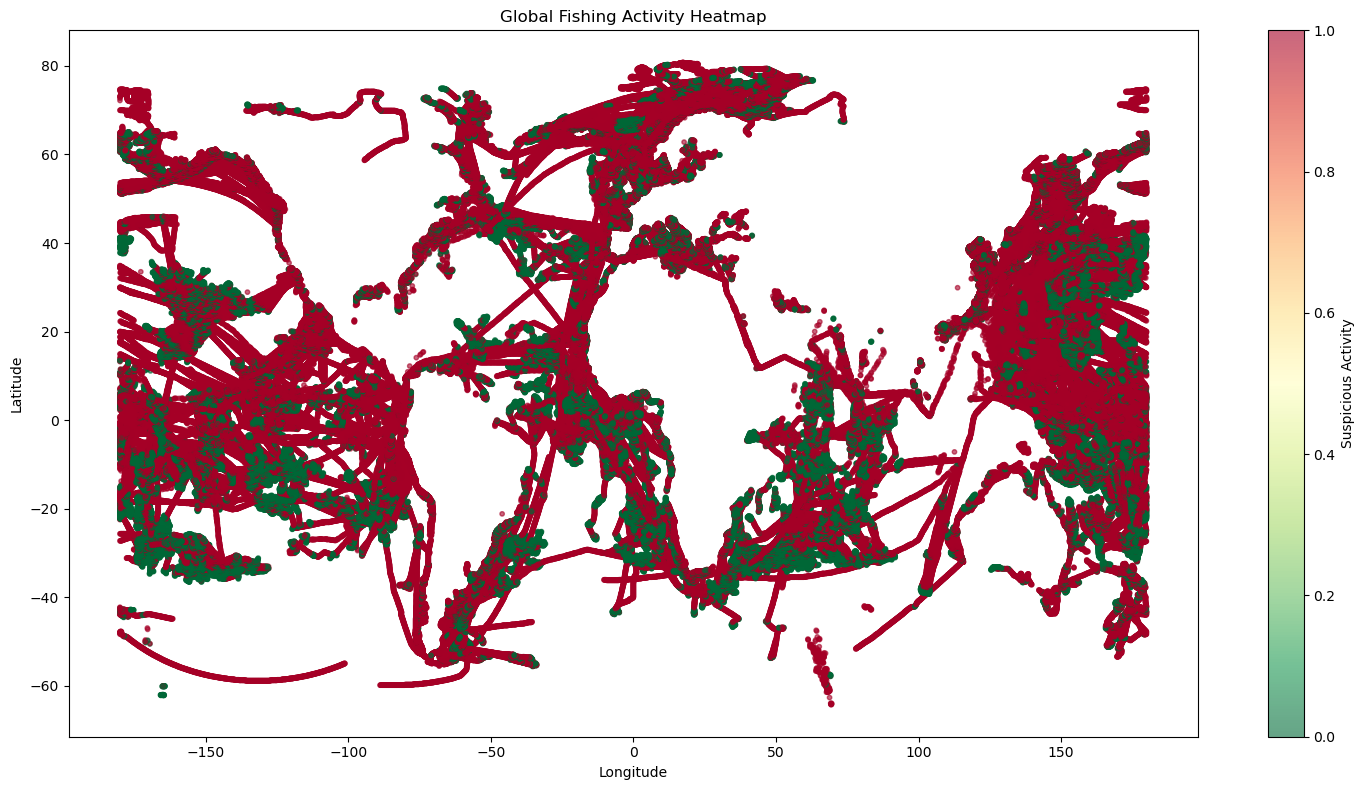

In [25]:
# 3.1 Geospatial Visualization
plt.figure(figsize=(15, 8))
plt.scatter(df['cell_ll_lon'], df['cell_ll_lat'], 
           c=df['suspicious'], cmap='RdYlGn_r', alpha=0.6, s=10)
plt.colorbar(label='Suspicious Activity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Global Fishing Activity Heatmap')
plt.tight_layout()
plt.savefig('fishing_heatmap.png', dpi=300)
plt.show()

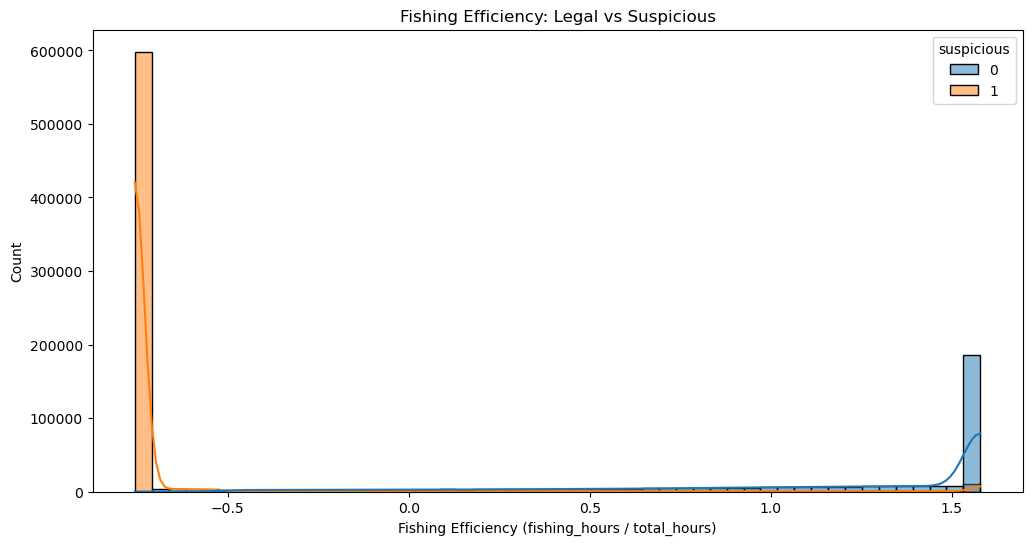

In [26]:
# 3.2 Fishing Efficiency Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='fishing_efficiency', hue='suspicious', bins=50, kde=True)
plt.title('Fishing Efficiency: Legal vs Suspicious')
plt.xlabel('Fishing Efficiency (fishing_hours / total_hours)')
plt.ylabel('Count')
plt.savefig('fishing_efficiency.png', dpi=300)
plt.show()

<Figure size 1400x600 with 0 Axes>

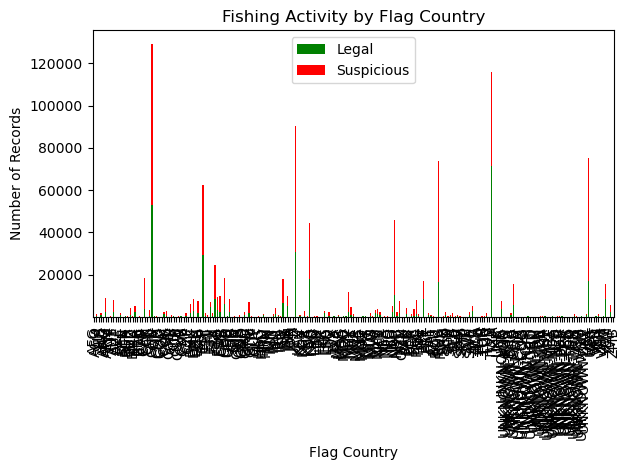

In [29]:
# 3.3 Activity by Flag Country
plt.figure(figsize=(14, 6))
flag_counts = df.groupby(['flag', 'suspicious']).size().unstack(fill_value=0)
flag_counts.plot(kind='bar', stacked=True, color=['green', 'red'])
plt.title('Fishing Activity by Flag Country')
plt.xlabel('Flag Country')
plt.ylabel('Number of Records')
plt.legend(['Legal', 'Suspicious'])
plt.tight_layout()
plt.savefig('flag_activity.png', dpi=300)
plt.show()

<Figure size 1200x600 with 0 Axes>

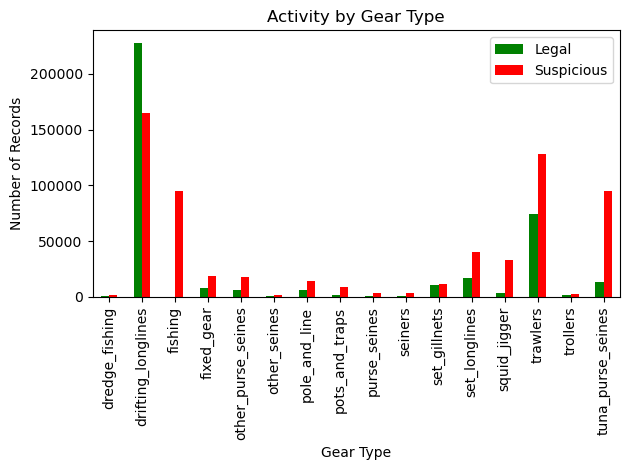

In [31]:
# 3.4 Gear Type Analysis
plt.figure(figsize=(12, 6))
gear_counts = df.groupby(['geartype', 'suspicious']).size().unstack(fill_value=0)
gear_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Activity by Gear Type')
plt.xlabel('Gear Type')
plt.ylabel('Number of Records')
plt.legend(['Legal', 'Suspicious'])
plt.tight_layout()
plt.savefig('gear_activity.png', dpi=300)
plt.show()

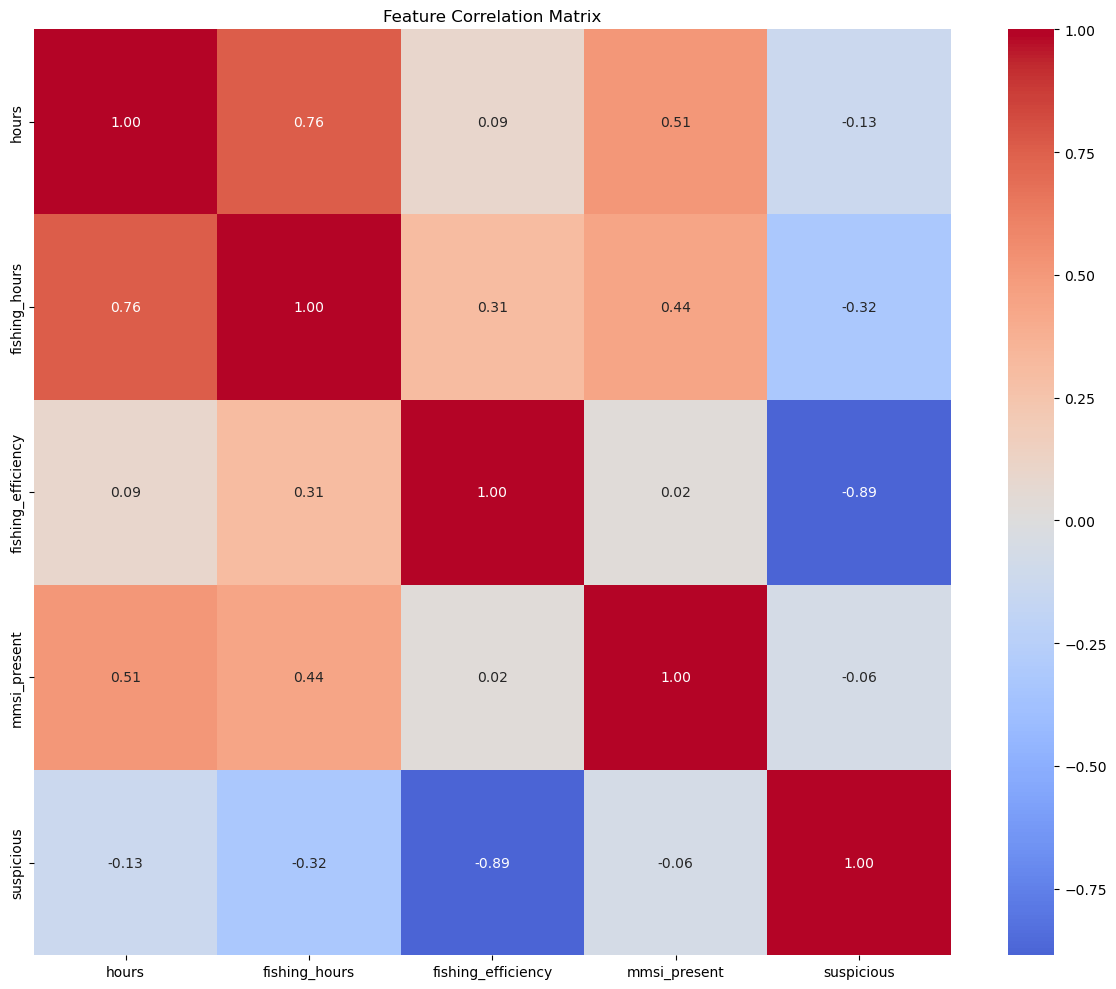

In [37]:
# 3.5 Correlation Matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df[feature_cols + ['suspicious']].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300)
plt.show()


<Figure size 1200x600 with 0 Axes>

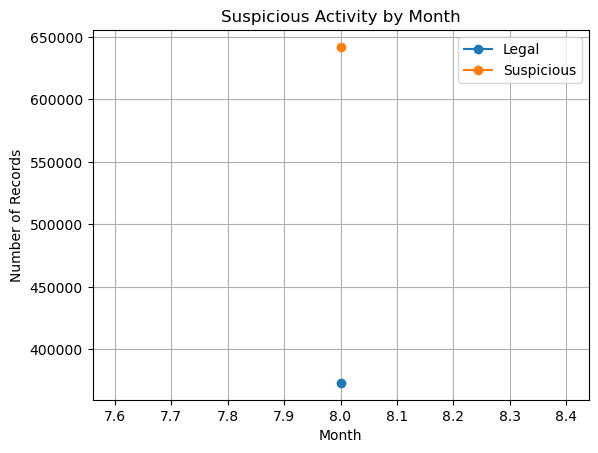

In [39]:
# 3.6 Temporal Patterns
plt.figure(figsize=(12, 6))
temporal = df.groupby(['month', 'suspicious']).size().unstack(fill_value=0)
temporal.plot(kind='line', marker='o')
plt.title('Suspicious Activity by Month')
plt.xlabel('Month')
plt.ylabel('Number of Records')
plt.legend(['Legal', 'Suspicious'])
plt.grid(True)
plt.savefig('temporal_patterns.png', dpi=300)
plt.show()

In [67]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Select features
cluster_features = df[['hours', 'fishing_hours', 'fishing_efficiency', 'mmsi_present']]

# Use a smaller sample for silhouette & elbow
sampled = cluster_features.sample(n=min(2000, len(cluster_features)), random_state=42)

inertias = []
K_range = range(2, 8)  # restrict to 2–7 to reduce computation

for k in K_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=512)
    kmeans.fit(sampled)
    inertias.append(kmeans.inertia_)

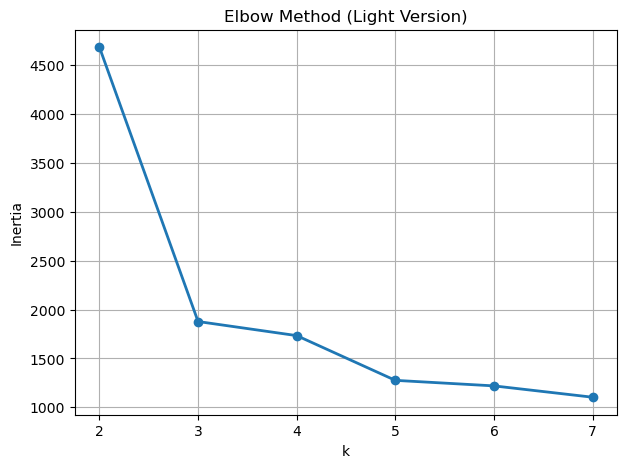

Silhouette Score for k = 4 : 0.7676194606501895

=== CLUSTER ANALYSIS ===
            hours  fishing_hours  fishing_efficiency  suspicious
cluster                                                         
0       -0.120264       0.078718            1.346481    0.060953
1        6.141864       6.567878            0.632083    0.229196
2       -0.207783      -0.299766           -0.711344    0.942314
3        2.386461       2.084463            0.507325    0.326165


In [69]:
# Plot only Elbow Curve (silhouette is expensive)
plt.figure(figsize=(7,5))
plt.plot(K_range, inertias, marker='o', linewidth=2)
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method (Light Version)')
plt.grid(True)
plt.show()

# Pick optimal k manually (e.g., sharp bend at 3 or 4)
optimal_k = 4

# Final clustering on the full dataset (still MiniBatchKMeans)
kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=512)
df['cluster'] = kmeans.fit_predict(cluster_features)

# Compute silhouette only once (on sample)
sil_score = silhouette_score(sampled, 
                             MiniBatchKMeans(n_clusters=optimal_k, random_state=42)
                             .fit_predict(sampled))

print("Silhouette Score for k =", optimal_k, ":", sil_score)

# Show cluster summary
print("\n=== CLUSTER ANALYSIS ===")
cluster_summary = df.groupby('cluster')[['hours', 'fishing_hours', 
                                         'fishing_efficiency', 'suspicious']].mean()
print(cluster_summary)


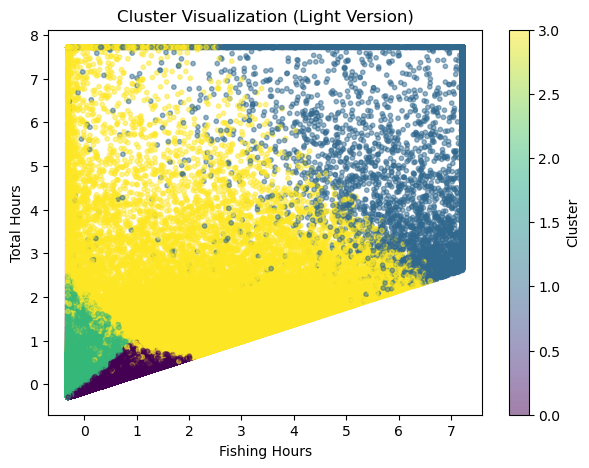

In [45]:
# Simple scatter plot
plt.figure(figsize=(7,5))
plt.scatter(df['fishing_hours'], df['hours'], 
            c=df['cluster'], cmap='viridis', alpha=0.5, s=10)
plt.colorbar(label='Cluster')
plt.xlabel('Fishing Hours')
plt.ylabel('Total Hours')
plt.title('Cluster Visualization (Light Version)')
plt.show()


In [55]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [59]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [71]:
pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/72.0 MB 2.4 MB/s eta 0:00:30
    --------------------------------------- 1.3/72.0 MB 3.4 MB/s eta 0:00:22
   - -------------------------------------- 2.1/72.0 MB 3.4 MB/s eta 0:00:21
   - -------------------------------------- 2.6/72.0 MB 3.4 MB/s eta 0:00:21
   -- ------------------------------------- 3.9/72.0 MB 4.0 MB/s eta 0:00:17
   -- ------------------------------------- 4.7/72.0 MB 4.0 MB/s eta 0:00:17
   --- ------------------------------------ 5.5/72.0 MB 3.9 MB/s eta 0:00:17
   --- ------------------------------------ 6.0/72.0 MB 4.1 MB/s eta 0:00:17
   --- ------------------------------------ 6.8/72.0 MB 3.8 MB/s eta 0:00:18
   ---- ----------------------------------- 7.6/72.0 MB 3.8 MB/s eta 0:00:17
   ---- ----------------------------------- 8.1/72.0 MB 3.7 MB/s eta 0:00:18
   ----- ----

In [73]:
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, classification_report)

import pandas as pd


In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape)
print("Test:", X_test.shape)

results = []
predictions = {}


Train: (812205, 4)
Test: (203052, 4)


In [77]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred))

results.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_prob)
})
predictions['Logistic Regression'] = y_pred


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.93      0.90      0.91     74637
           1       0.94      0.96      0.95    128415

    accuracy                           0.94    203052
   macro avg       0.94      0.93      0.93    203052
weighted avg       0.94      0.94      0.94    203052



In [79]:
model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("=== Naive Bayes ===")
print(classification_report(y_test, y_pred))

results.append({
    'Model': 'Naive Bayes',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_prob)
})
predictions['Naive Bayes'] = y_pred


=== Naive Bayes ===
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     74637
           1       0.94      0.95      0.95    128415

    accuracy                           0.93    203052
   macro avg       0.93      0.92      0.92    203052
weighted avg       0.93      0.93      0.93    203052



In [81]:
model = DecisionTreeClassifier(max_depth=10, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("=== Decision Tree ===")
print(classification_report(y_test, y_pred))

results.append({
    'Model': 'Decision Tree',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_pred)
})
predictions['Decision Tree'] = y_pred


=== Decision Tree ===
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     74637
           1       1.00      0.95      0.97    128415

    accuracy                           0.97    203052
   macro avg       0.96      0.98      0.97    203052
weighted avg       0.97      0.97      0.97    203052



In [83]:
model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("=== Random Forest ===")
print(classification_report(y_test, y_pred))

results.append({
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_prob)
})
predictions['Random Forest'] = y_pred


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     74637
           1       1.00      0.95      0.98    128415

    accuracy                           0.97    203052
   macro avg       0.96      0.98      0.97    203052
weighted avg       0.97      0.97      0.97    203052



In [85]:
model = XGBClassifier(
    n_estimators=80,          # lighter  
    max_depth=6,             # reduce RAM
    learning_rate=0.1,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    tree_method='hist'       # fastest method
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("=== XGBoost ===")
print(classification_report(y_test, y_pred))

results.append({
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_prob)
})
predictions['XGBoost'] = y_pred


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     74637
           1       1.00      0.95      0.97    128415

    accuracy                           0.97    203052
   macro avg       0.96      0.97      0.97    203052
weighted avg       0.97      0.97      0.97    203052



In [ ]:
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("=== SVM (Linear) ===")
print(classification_report(y_test, y_pred))

results.append({
    'Model': 'SVM (Linear)',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_prob)
})
predictions['SVM (Linear)'] = y_pred


In [ ]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("=== KNN ===")
print(classification_report(y_test, y_pred))

results.append({
    'Model': 'KNN',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_pred)
})
predictions['KNN'] = y_pred


In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].plot(
    kind='bar', ax=ax, rot=45
)

plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.legend(loc='lower right')
plt.ylim(0, 1.1)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns

for name, y_pred in predictions.items():
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                cbar=False, annot_kws={'size': 12})
    
    plt.title(f'{name} - Confusion Matrix', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 7))

for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC={roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
rf_model = models['Random Forest']

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance, y='Feature', x='Importance', palette='viridis')
plt.title('Random Forest Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("Top 5 Features:")
print(feature_importance.head())


In [ ]:
rf_model = models['Random Forest']

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance, y='Feature', x='Importance', palette='viridis')
plt.title('Random Forest Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("Top 5 Features:")
print(feature_importance.head())


In [ ]:
import joblib

# Save best model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

joblib.dump(best_model, f'{best_model_name.replace(" ", "_")}_model.pkl')
print(f"\nBest Model ({best_model_name}) saved!")

# Save results to CSV
results_df.to_csv('model_comparison_results.csv', index=False)
print("Results saved to 'model_comparison_results.csv'")

# Save processed data
df.to_csv('processed_fishing_data.csv', index=False)
print("Processed data saved!")
